In [80]:
import numpy as np
import pandas as pd
import random
import torch
from d2l import torch as d2l


In [81]:
dev = d2l.try_gpu()

In [82]:
def synthetic_data(w, b, num_examples): 
    '''生成 y=Xw+b+噪声'''
    X = torch.normal(0, 1, (num_examples, len(w)), device=dev)
    y = torch.matmul(X, w)+ b
    y += torch.normal(0, 0.01, y.shape, device=dev)
    return X, y.reshape((-1, 1))  

In [83]:
from torch.utils.data import Dataset
class MyDataset(Dataset):


    def __init__(self, txt_path):
        fh = open(txt_path, 'r')
        labels = []
        features = []
        for line in fh:
            line = line.rstrip()
            datas= line.split(',')
            features.append([int(datas[0]),int(datas[1])])
            labels.append(int(datas[2]))
            self.features = torch.Tensor(features)
            self.labels = torch.Tensor(labels)

    def __len__(self):
        return len(self.labels)


In [84]:
data = MyDataset('data/ex1data2.txt')

features, labels = data.features.to(dev), data.labels.to(dev)

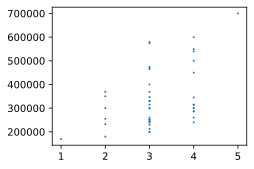

In [85]:
d2l.set_figsize()
d2l.plt.scatter(features[:, 1].detach().to('cpu').numpy(), labels.detach().to('cpu').numpy(), 1) 

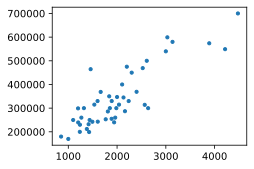

In [86]:
d2l.set_figsize()
d2l.plt.scatter(features[:, 0].detach().to('cpu').numpy(), labels.detach().to('cpu').numpy(), 10)

In [87]:
# 归一化
import torch.nn.functional as F

features = F.normalize(features, p=2, dim=0)
labels = F.normalize(labels, p=2, dim=0)

In [88]:
def data_iter(batch_size, features, labels): 
    num_examples = len(features)
    
    indices = list(range(num_examples))
    random.shuffle(indices)  
    for i in range(0, num_examples, batch_size):  
        batch_indices = torch.tensor(indices[i:min(i + batch_size, num_examples)], device=dev)
        yield features[batch_indices], labels[batch_indices]

In [89]:
from torch.utils import data

def load_array(data_arrays, batch_size, is_train=True):
    """Construct a Pytorch data iterator"""
    dataset = data.TensorDataset(*data_arrays)
    return data.DataLoader(dataset, batch_size, shuffle=is_train)

In [90]:
batch_size = 10
data_iter = load_array((features, labels), batch_size)

next(iter(data_iter))

[tensor([[0.1282, 0.1343],
         [0.0841, 0.1343],
         [0.2036, 0.1791],
         [0.1467, 0.1791],
         [0.0814, 0.1343],
         [0.1331, 0.1791],
         [0.1248, 0.0895],
         [0.2640, 0.1343],
         [0.1281, 0.0895],
         [0.0679, 0.0448]], device='mps:0'),
 tensor([0.1611, 0.1611, 0.1611, 0.1611, 0.1611, 0.1611, 0.1611, 0.1611, 0.1611,
         0.1611], device='mps:0')]

In [91]:
for X, y in data_iter: 
    print(X, '\n', y)  

tensor([[0.1014, 0.1343],
        [0.1248, 0.0895],
        [0.1199, 0.1343],
        [0.2036, 0.1791],
        [0.0975, 0.1343],
        [0.1742, 0.1791],
        [0.0968, 0.1343],
        [0.1281, 0.0895],
        [0.1129, 0.0895],
        [0.1789, 0.1343]], device='mps:0') 
 tensor([0.1611, 0.1611, 0.1611, 0.1611, 0.1611, 0.1611, 0.1611, 0.1611, 0.1611,
        0.1611], device='mps:0')
tensor([[0.3039, 0.2238],
        [0.1714, 0.1343],
        [0.1086, 0.1343],
        [0.1347, 0.1791],
        [0.1088, 0.1343],
        [0.2057, 0.1791],
        [0.0936, 0.1343],
        [0.1041, 0.1343],
        [0.1629, 0.1343],
        [0.0679, 0.0448]], device='mps:0') 
 tensor([0.1611, 0.1611, 0.1611, 0.1611, 0.1611, 0.1611, 0.1611, 0.1611, 0.1611,
        0.1611], device='mps:0')
tensor([[0.1770, 0.1791],
        [0.2860, 0.1791],
        [0.0746, 0.1343],
        [0.0841, 0.1343],
        [0.1447, 0.1791],
        [0.1519, 0.1343],
        [0.1282, 0.1343],
        [0.0814, 0.1343],
        

In [96]:
from torch import nn


lr = 0.001  # 首先指定一些超参数：学习率为0.03
num_epochs = 3  # epoch为3表示把整个数据扫3遍
# net = linreg  # network为linreg前面定义的线性回归模型
net = nn.Sequential(nn.Linear(2,1,device=dev))
# loss = squared_loss  # loss为均方损失
loss = nn.MSELoss()

In [97]:
net[0].weight.data.normal_(0, 0.01)
net[0].bias.data.fill_(0)


tensor([0.], device='mps:0')

In [98]:
trainer = torch.optim.SGD(net.parameters(), lr)

for epoch in range(num_epochs):  
    for x, y in data_iter:
        l = loss(net(x), y)
        trainer.zero_grad()
        l.backward()
        trainer.step()
    l = loss(net(features), labels)
    print(f'epoch{epoch + 1}, loss{l:f}')


epoch1, loss0.000541
epoch2, loss0.000541
epoch3, loss0.000546


In [95]:
# print(f'w的估计误差: {true_w - w.reshape(true_w.shape)}')
# print(f'b的估计误差: {true_b - b}')